# Energy Bins from SPAN


In [39]:
#!pip install wget
import wget
import cdflib
import numpy as np
from datetime import datetime
import os.path
import bisect
import matplotlib.pyplot as plt

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

## Data Download

In [40]:
year=2023
month=3
day=16

user_datetime = datetime(year,month,day)

def yyyymmdd(dt) : return f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

#Import from file directory
VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{yyyymmdd(user_datetime)}_v04.cdf'

#check if file is already downloaded. If so, skip download. If not, download in local directory.
if os.path.isfile(VDfile_filename):
    print(f"File already exists in local directory - [{VDfile_filename}]")
    VDfile = VDfile_filename
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

File already exists in local directory - [psp_swp_spi_sf00_L2_8Dx32Ex8A_20230316_v04.cdf]


In [41]:
dat = cdflib.CDF(VDfile)

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)

([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


In [42]:
epoch_ns        = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

In [54]:
#convert time
import datetime
datetime_t0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))

hour = 14
minute = 00
second = 00

timeSlice  = datetime.datetime(year, month, day, hour, minute, second)
print('Desired timeslice:',timeSlice)

#find index for desired timeslice
tSliceIndex  = bisect.bisect_left(epoch,timeSlice)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2023-03-16 14:00:00
time Index: 15664
Time of closest data point: 2023-03-16T14:00:02.638446


In [55]:
epochSlice  = epoch[tSliceIndex]
thetaSlice  = theta[tSliceIndex,:]
phiSlice    = phi[tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[tSliceIndex,:]

In [56]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


## Level 3 Data

In [9]:
import pyspedas
from pytplot import tplot, get_data, cdf_to_tplot
time_range = ['2023-03-16/18:00', '2023-03-17/00:00']
pvars = pyspedas.psp.spi(trange=time_range, datatype='sf00_l3_mom', 
                            level='l3', time_clip=True)
tplot(['psp_spi_VEL_INST'])
vinst = get_data('psp_spi_VEL_INST')
vinstx = vinst.y[:, 0]
vinsty = vinst.y[:, 1]
vinstz = vinst.y[:, 2]
vxm, vym, vzm = np.nanmean(vinstx), np.nanmean(vinsty), np.nanmean(vinstz)
vmag = np.sqrt(vxm**2 + vym**2 + vzm**2)
print(vxm, vym, vzm, vmag)

ModuleNotFoundError: No module named 'pyqtgraph.python2_3'

## Calculations

In [72]:
vxm, vym, vzm = -317, 172, 29
vmag = np.linalg.norm((vxm, vym, vzm))

In [73]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

In [74]:
vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
vz = vel *                                   np.sin(np.radians(thetaReshaped))

In [75]:
### find mean speed from VDF
fvx = np.sum(vx * vdf, axis=(0,2)) / np.sum(vdf, axis=(0,2))
print(np.sum(vdf, axis=(0, 2)))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6785479e+03 3.1443576e+04 6.3624953e+04
 2.8186912e+05 8.6108206e+05 3.9374488e+06 1.4530866e+07 3.5679556e+07
 3.9829424e+07 2.1836300e+07 9.8785550e+06 3.7989200e+06 0.0000000e+00
 1.0410856e+06 2.9382672e+06 0.0000000e+00 6.4574760e+06 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


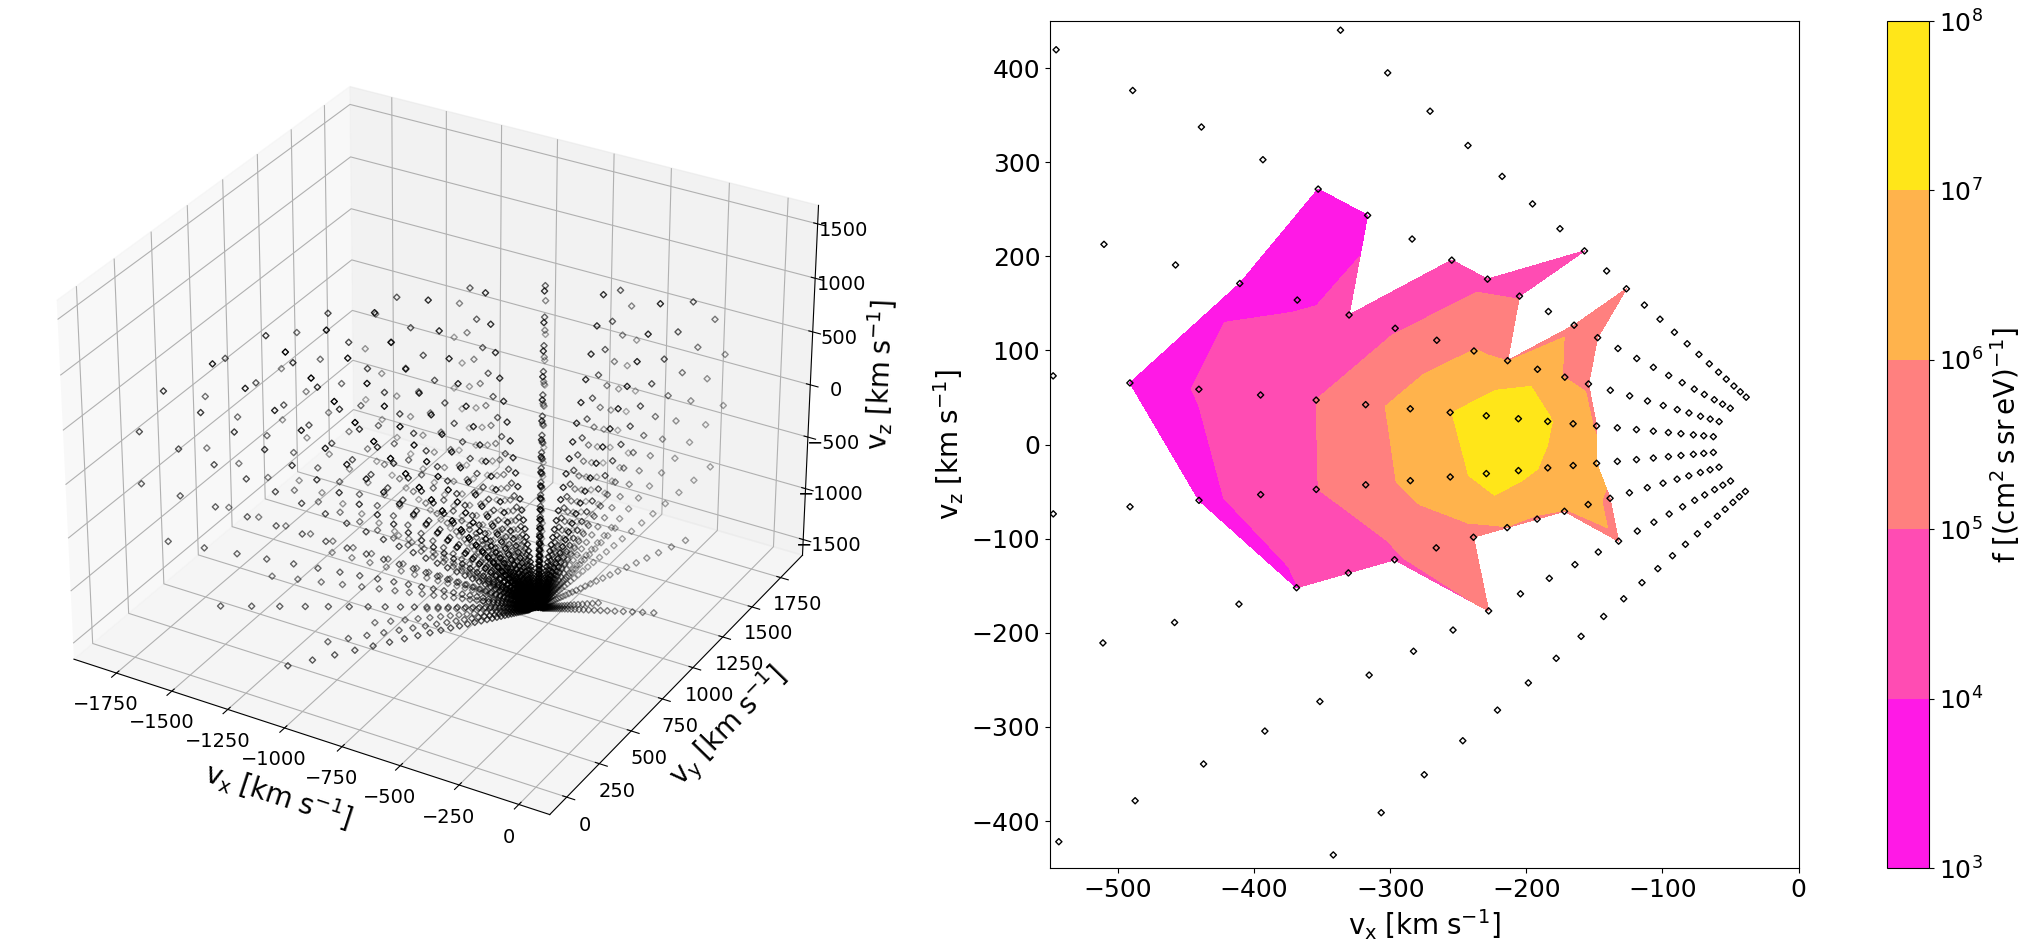

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import LogNorm

### SETUP FIGURE
fig = plt.figure(figsize=(25, 11))
fig.tight_layout()
grid = plt.GridSpec(1, 2, hspace=0.3) #height_ratios=[1, 1, 3], 

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, 0], projection='3d')
ax2 = fig.add_subplot(grid[0, 1])
# ax3 = fig.add_subplot(grid[0, 2])
# axs = [ax1, ax2, ax3]

# Create some sample data
vdf_allAngles = np.sum(vdf, axis=(0,2))
mean_vel = vel[0, :, 0][np.where(vdf_allAngles == np.nanmax(vdf_allAngles))[0]]

#### PANEL ONE: 3D PLOT
ax = ax1
dist = []
# Plot the 3D surface
for i in range(0, 32):
    x = vx[:, i, :]
    y = vy[:, i, :]
    z = vz[:, i, :]
    ax.scatter(x, y, z, facecolors='none', edgecolor='k', marker='D', s=10, label='Points')
    # calculate euclidian distance between each point and the mean
    distances = np.sqrt((x - vxm)**2 + (y - vym)**2 + (z - vzm)**2)
    dist.append(distances)
# ax.scatter(vxm, vym, vzm, c='k', label='Mean Vel', zorder=3, s=100)

# Add label
ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_y \; [km \; s^{-1}]$', fontsize=20)
ax.set_zlabel(r'$\rm v_z \; [km \; s^{-1}]$', fontsize=20)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10

ax.xaxis.set_rotate_label(True)
ax.yaxis.set_rotate_label(True)
ax.zaxis.set_rotate_label(True)

ax.zaxis.label.set_position((0.5, 0))
# mean_speed = [vxm, vym, vzm]
# plt.title('Mean Wind Speed: ' + str(mean_speed))

# ### PANEL TWO: EXAMPLE VDF IN PHI
# ax = ax2
# phi_cut = 1

# phi_plane = phiReshaped[:,:,phi_cut]
# theta_plane = thetaReshaped[:,:,phi_cut]
# energy_plane = energyReshaped[:,:,phi_cut]
# vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

# df_phi=np.nansum(vdf,axis=2)

# vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
# vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
# vz_plane_phi = vel_plane *                                   np.sin(np.radians(theta_plane))

# # plot the grid
# for i in range(0, 32):
#     x = vx[:, i, :]
#     y = vy[:, i, :]
#     ax.scatter(x, y,facecolors='none', edgecolor='k', marker='D', s=5, label='Points')

# cs=ax.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi),locator=ticker.LogLocator(),cmap=cm.cool)

# ### AXES LABELS
# ax.set(xlim=(-550, 50), xticks=np.arange(-500, 1, step=100), ylim=(-250, 650), yticks=np.arange(-200, 601, step=100))
# ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
# ax.set_ylabel(r'$\rm v_y \; [km \; s^{-1}]$', fontsize=20)
# # ax.set_title('VDF SPAN-I $\\theta$-plane')
# ax.tick_params(axis='both', which='major', labelsize=18) 


### PANEL THREE: EXAMPLE VDF IN THETA
ax = ax2
theta_cut=0 

phi_plane = phiReshaped[theta_cut,:,:]
theta_plane = thetaReshaped[theta_cut,:,:]
energy_plane = energyReshaped[theta_cut,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_theta=np.nansum(vdf,axis=0)

vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_theta = vel_plane *                                   np.sin(np.radians(theta_plane))

# plot the grid
for i in range(0, 32):
    x = vx[0, i, :]
    z = vz[0, i, :]
    ax.scatter(x, z,facecolors='none', edgecolor='k', marker='D', s=10, label='Points', zorder=10)
levs = [10e0, 10e1, 10e2, 10e3, 10e4, 10e5, 10e6, 10e7, 10e8]
cs=ax.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap='spring')
cbar = plt.colorbar(cs, ax=ax, pad=0.1, fraction=0.05, ticks=ticker.LogLocator(numticks=10))
cbar.set_label(r'$\rm f \; [(cm^2 \, s \, sr \, eV)^{-1}]$', fontsize=20)
cbar.ax.yaxis.set_tick_params(labelsize=18)  # Set font size for colorbar ticks

### SET AXES LABELS
ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_z \; [km \; s^{-1}]$', fontsize=20)

ax.set(xlim=(-550, 0), xticks=np.arange(-500, 1, step=100), ylim=(-450, 450), yticks=np.arange(-400, 401, step=100))
ax.tick_params(axis='both', which='major', labelsize=18) 

### SAVE FIGURE
# plt.savefig(os.path.join('figures', 'fig12.png'), bbox_inches='tight')
# plt.savefig(os.path.join('eps_figures', 'fig12.eps'), bbox_inches='tight')

### OLD
# ax.xaxis.labelpad = 10
# ax.yaxis.labelpad = 10
# ax.zaxis.labelpad = 10

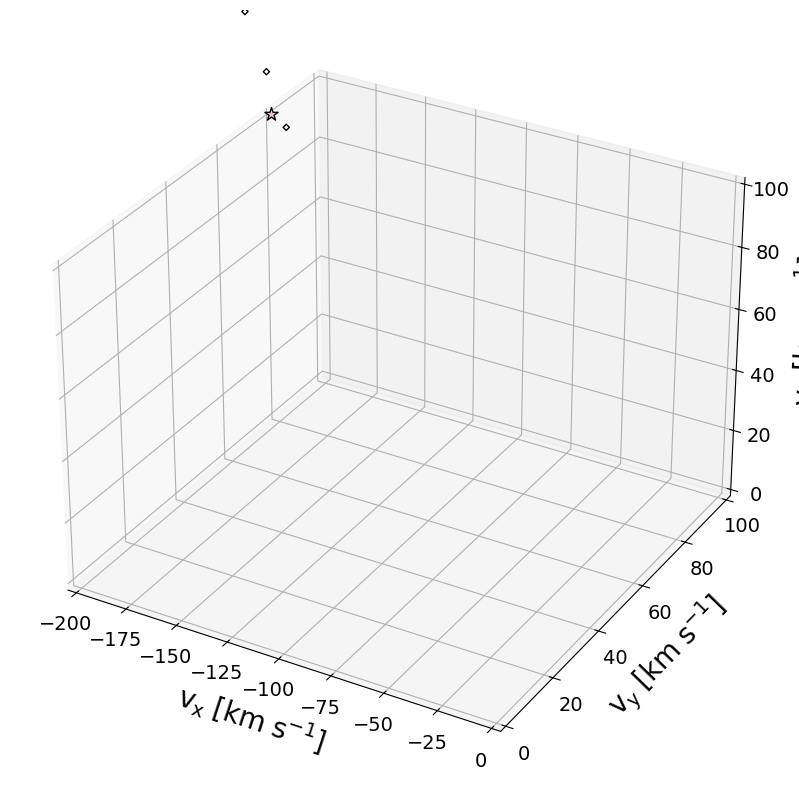

In [77]:
# Create some sample data
vdf_allAngles = np.sum(vdf, axis=(0,2))
mean_vel = vel[0, :, 0][np.where(vdf_allAngles == np.nanmax(vdf_allAngles))[0]]

#### PANEL ONE: 3D PLOT
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='3d')
dist = []
miss=40
x_limit = [vxm-miss, vxm+miss]
y_limit = [vym-miss, vym+miss]
z_limit=[vzm-miss, vzm+miss]
# Plot the 3D surface
for i in range(0, 32):
    x = vx[:, i, :]
    y = vy[:, i, :]
    z = vz[:, i, :]
    mask = (x >= x_limit[0]) & (x <= x_limit[1]) & (y >= y_limit[0]) & (y <= y_limit[1]) & (z >= z_limit[0]) & (z <= z_limit[1])

    ax.scatter(x[mask], y[mask], z[mask], facecolors='none', edgecolor='k', marker='D', s=10, label='Points')
    # calculate euclidian distance between each point and the mean
    distances = np.sqrt((x - vxm)**2 + (y - vym)**2 + (z - vzm)**2)
    dist.append(distances)
    ax.set(xlim=(-200, 0),ylim=(0, 100), zlim=(0,100))
ax.scatter(vxm, vym, vzm, c='pink', edgecolor='k', marker='*', label='Mean Vel', zorder=3, s=100)
ax.set(xlim=(-200, 0),ylim=(0, 100), zlim=(0,100))
# Add label
ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_y \; [km \; s^{-1}]$', fontsize=20)
ax.set_zlabel(r'$\rm v_z \; [km \; s^{-1}]$', fontsize=20)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10

ax.xaxis.set_rotate_label(True)
ax.yaxis.set_rotate_label(True)
ax.zaxis.set_rotate_label(True)

ax.zaxis.label.set_position((0.5, 0))

In [81]:
vxm, vym, vzm = -292.36365, 155.292, 29.402987
xx, yy, zz, distance = [], [], [], []
for i in range(0, 32):
    x = vx[:, i, :]
    y = vy[:, i, :]
    z = vz[:, i, :]
    xx.append(x)
    yy.append(y)
    zz.append(z)
    distance.append([np.sqrt((point[0] - vxm)**2 + (point[1] - vym)**2+ (point[2] - vzm)**2) for point in zip(x, y, z)])


(0.0, 100.0)

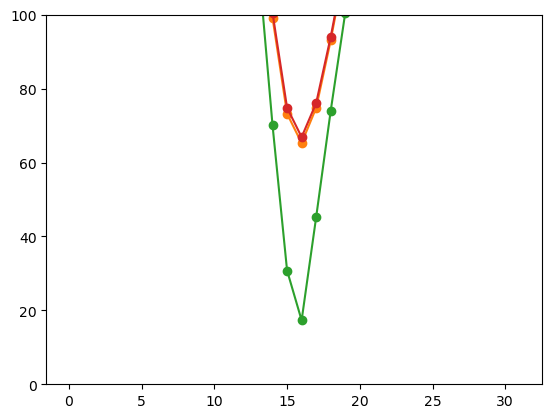

In [82]:
use = [[np.nanmin(dd) for dd in dist] for dist in distance]
plt.plot(use, marker='o')
plt.ylim(0, 100)

In [83]:
# Flatten the list of lists
flat_data = [value for sublist in use for value in sublist]

# Find the eight smallest values
eight_smallest = sorted(flat_data)[:8]
print("The eight smallest values are:", eight_smallest)
print(np.nanmean(eight_smallest))

The eight smallest values are: [17.304064, 30.781591, 45.22074, 65.251236, 66.882, 70.098114, 73.20035, 73.99845]
55.342064


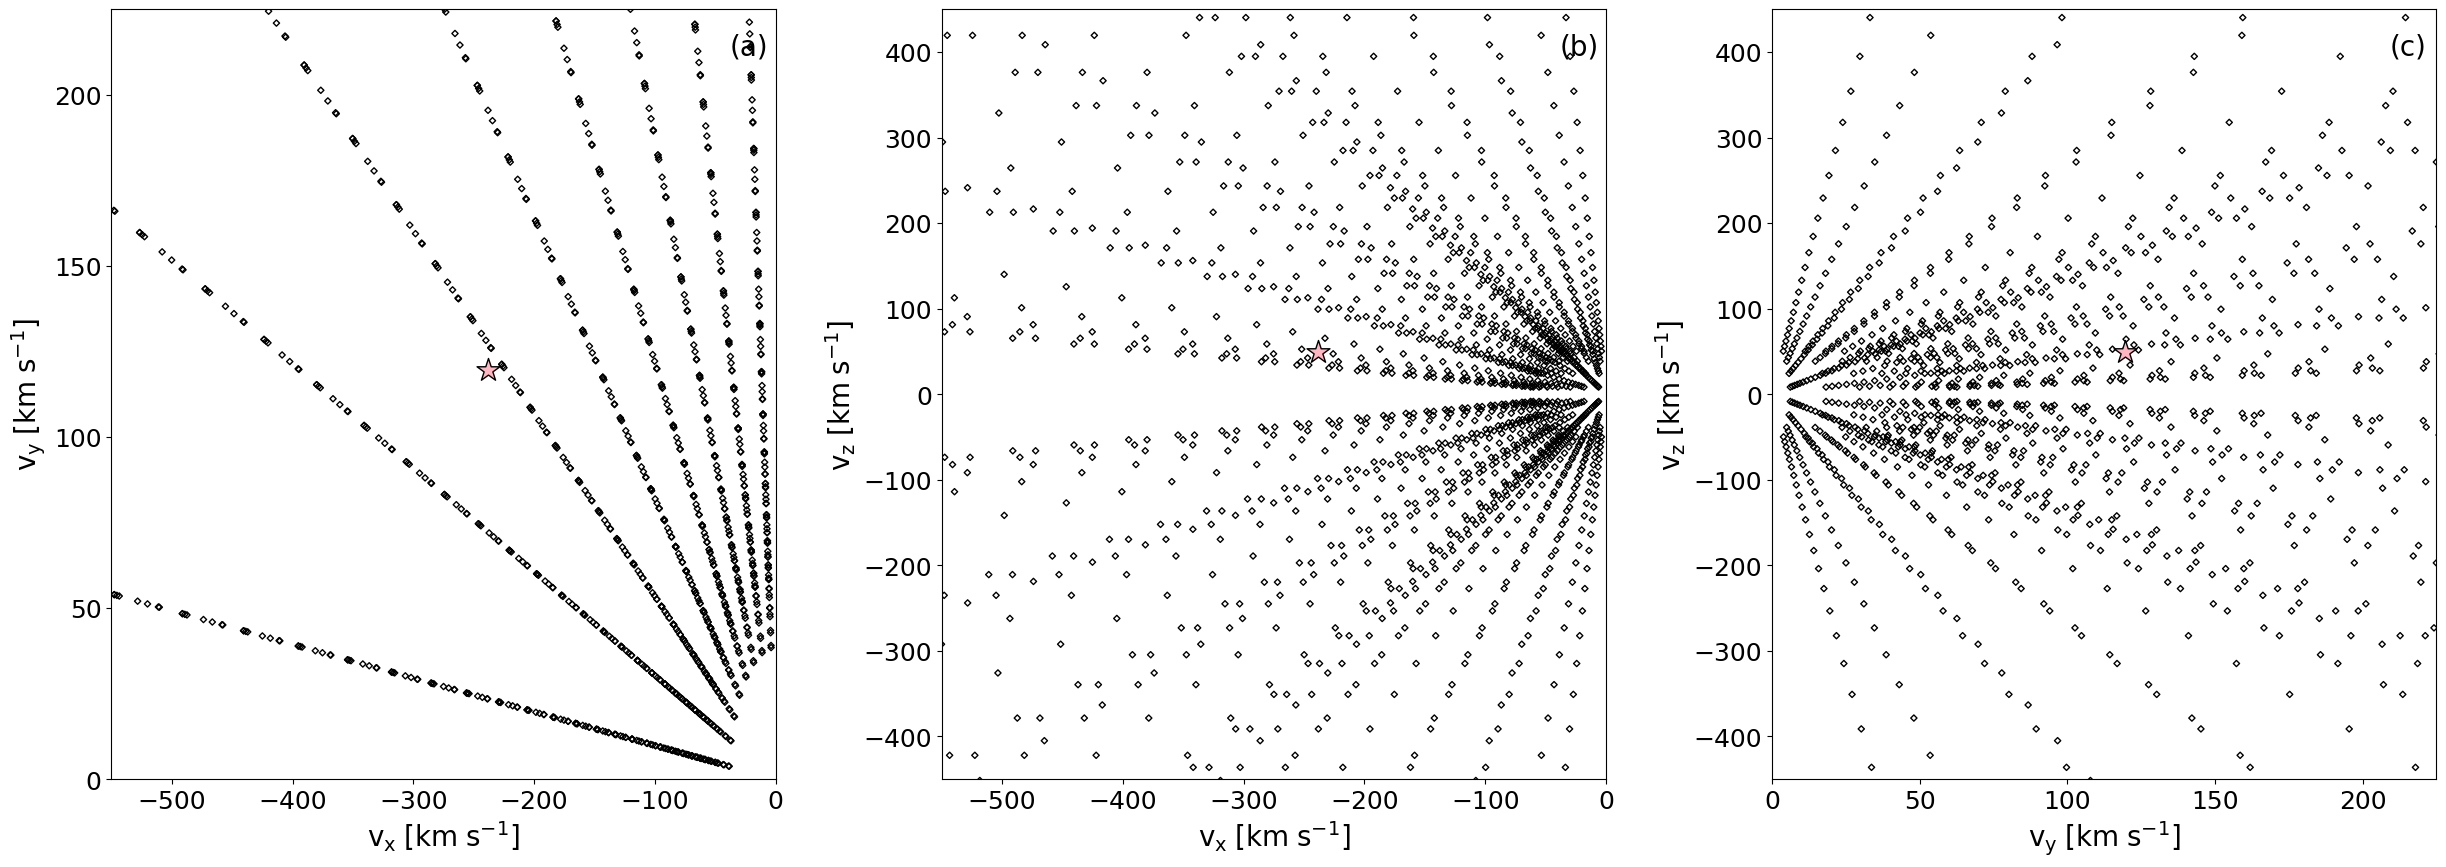

In [40]:
### PLOT THE CLOSEST POINTS
fig, axs = plt.subplots(1, 3, figsize=[30, 10], gridspec_kw={'hspace':.2, 'wspace':.25})

#### X&Y GRID
ax = axs[0]
for i in range(0, 32):
    x = vx[:, i, :]
    y = vy[:, i, :]
    ax.scatter(x, y,facecolors='none', edgecolor='k', marker='D', s=10, label='Points')
ax.scatter(vxm, vym, c='lightpink', marker='*', edgecolor='k', label='Mean Vel', zorder=3, s=300)
### SET AXES LABELS
ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_y \; [km \; s^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set(xlim=(-550, 0), xticks=np.arange(-500, 1, step=100), ylim=(0, 225), yticks=np.arange(0, 201, step=50))
ax.text(0.93, 0.97, '(a)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### X&Z GRID
ax = axs[1]
for i in range(0, 32):
    x = vx[:, i, :]
    z = vz[:, i, :]
    ax.scatter(x, z, facecolors='none', edgecolor='k', marker='D', s=10, label='Points')
ax.scatter(vxm, vzm, c='lightpink', marker='*', edgecolor='k', label='Mean Vel', zorder=3, s=300)

### SET AXES LABELS
ax.set_xlabel(r'$\rm v_x \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_z \; [km \; s^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set(xlim=(-550, 0), xticks=np.arange(-500, 1, step=100), ylim=(-450, 450), yticks=np.arange(-400, 401, step=100))
ax.text(0.93, 0.97, '(b)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

#### Y&Z GRID
ax = axs[2]
for i in range(0, 32):
    y = vy[:, i, :]
    z = vz[:, i, :]
    ax.scatter(y, z, facecolors='none', edgecolor='k', marker='D', s=10, label='Points')
ax.scatter(vym, vzm, c='lightpink', edgecolor='k', marker='*', label='Mean Vel', zorder=3, s=300)

### SET AXES LABELS
ax.set_xlabel(r'$\rm v_y \; [km \; s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\rm v_z \; [km \; s^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set(xlim=(0, 225), xticks=np.arange(0, 201, step=50), ylim=(-450, 450), yticks=np.arange(-400, 401, step=100))
ax.text(0.93, 0.97, '(c)', transform=ax.transAxes, fontsize=20, va='top', ha='left')

### SAVE FIGURE
plt.savefig(os.path.join('figures', 'span_vmom.png'), bbox_inches='tight')
plt.savefig(os.path.join('eps_figures', 'span_vmom.eps'), bbox_inches='tight')


20-Feb-24 11:12:30: <>:12: DeprecationWarning: invalid escape sequence \p

20-Feb-24 11:12:30: <>:12: DeprecationWarning: invalid escape sequence \p

20-Feb-24 11:12:30: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_10608/211469877.py:12: DeprecationWarning: invalid escape sequence \p
  ax.set_ylabel('$\phi$')



Text(0.5, 0, '$v_{avg}$')

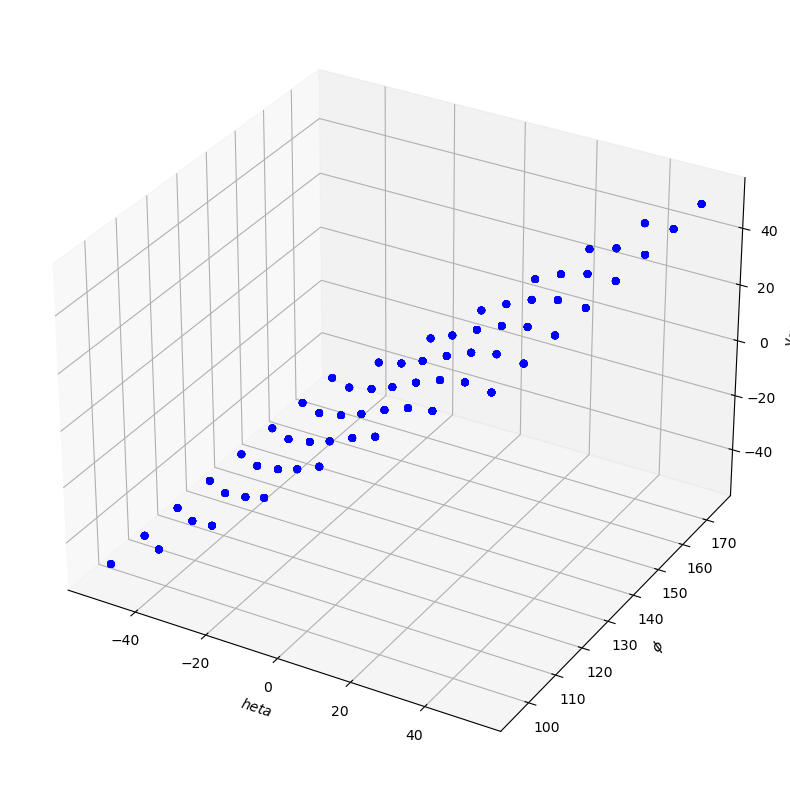

In [30]:
# Create a 3D plot of theta v. phi v. velocity
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
# Plot the 3D surface
for i in range(0, 32):
    x = thetaReshaped[:, i, :]
    y = phiReshaped[:, i, :]
    # z = mean_vel_arr[i, :, :]
    ax.scatter(x, y, z, c='b', marker='o', label='Points', zorder=1)
# Add labels
ax.set_xlabel('$\theta$')
ax.set_ylabel('$\phi$')
ax.set_zlabel('$v_{avg}$')



## Plotting

In [ ]:
#sum over both phi and theta 
vdf_allAngles = np.sum(vdf, axis=(0,2))
mean_vel = vel[0, :, 0][np.where(vdf_allAngles == np.nanmax(vdf_allAngles))[0]]
print(mean_vel)

#plot and set limits/labels
plt.plot(vel[0,:,0],vdf_allAngles)
plt.scatter(mean_vel, np.nanmax(vdf_allAngles), c='k')
plt.yscale('log')
plt.xlim(0,1000)
plt.ylabel(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')
plt.xlabel('Velocity (km/s)')



In [ ]:
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\\theta$');

In [ ]:
vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set(xlim=(0, 1000),yscale='log', xlabel='Velocity (km/s)', ylabel=f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$',title='f(v) summed over $\phi$');


In [ ]:
#theta is along dimension 0, while phi is along 2
#first cut through theta
theta_cut=0

phi_plane = phiReshaped[theta_cut,:,:]
theta_plane = thetaReshaped[theta_cut,:,:]
energy_plane = energyReshaped[theta_cut,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_theta=np.nansum(vdf,axis=0)

vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_theta = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane_theta, vz_plane_theta, df_theta,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-500,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_z$ km/s')
ax.set_title('VDF SPAN-I $\\theta$-plane')

In [ ]:
#now repeat for phi dimension
phi_cut = 0

phi_plane = phiReshaped[:,:,phi_cut]
theta_plane = thetaReshaped[:,:,phi_cut]
energy_plane = energyReshaped[:,:,phi_cut]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df_phi=np.nansum(vdf,axis=2)

vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane_phi = vel_plane *                                   np.sin(np.radians(theta_plane))

fig,ax=plt.subplots()
cs=ax.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi),locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-700,0)
ax.set_ylim(-200,500)
ax.set_xlabel('$v_x$ km/s')
ax.set_ylabel('$v_y$ km/s')
ax.set_title('VDF SPAN-I $\\phi$-plane')